In [98]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# First, we import the four csv files that we are going to use
df1 = pd.read_csv("./data/caracteristics.csv", encoding='latin-1')
df2 = pd.read_csv("./data/places.csv")
df3 = pd.read_csv("./data/users.csv")
df4 = pd.read_csv("./data/vehicles.csv")

# Then, we merge all the dataframes together using the column 'Num_Acc' that they have in common
df1 = pd.merge(df1, df2, how="outer", on="Num_Acc")
df2 = pd.merge(df3, df4, how='outer', on="Num_Acc")

data = pd.merge(df1, df2, how='outer', on="Num_Acc")

In [99]:
# Here, we select the columns that we want to keep and we rename it appropriately
columns = ['an', 'mois', 'grav', 'lat', 'long']

data = data[columns]
data.columns = ['Year', 'Month', 'Severity', 'Latitude', 'Longitude']

data.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)

data['Severity'].replace({2: 4, 4: 2}, inplace=True)

severity_description = {
    1: "Unscathed",
    2: "Light injury",
    3: "Hospitalized wounded",
    4: "Killed"
}

data

,Year,Month,Severity,Latitude,Longitude
0,16,2,1,0.0,0.0
1,16,2,1,0.0,0.0
2,16,2,3,0.0,0.0
3,16,2,3,0.0,0.0
4,16,3,3,0.0,0.0
...,...,...,...,...,...
3552260,5,12,1,0.0,0.0
3552261,5,12,3,0.0,0.0
3552262,5,12,3,0.0,0.0
3552263,5,12,3,0.0,0.0


In [100]:
import numpy as np
import seaborn as sns

# Data processing
data['Longitude'] = data['Longitude'].replace('-', 0).astype('double')
data['Latitude'] = data['Latitude'].replace('-', 0).astype('double')

# Data filtering
data = data.loc[(data['Longitude'] < 3*10**6) & (data['Latitude'] > 3*10**6) & (data['Latitude'] < 5.2*10**6)]

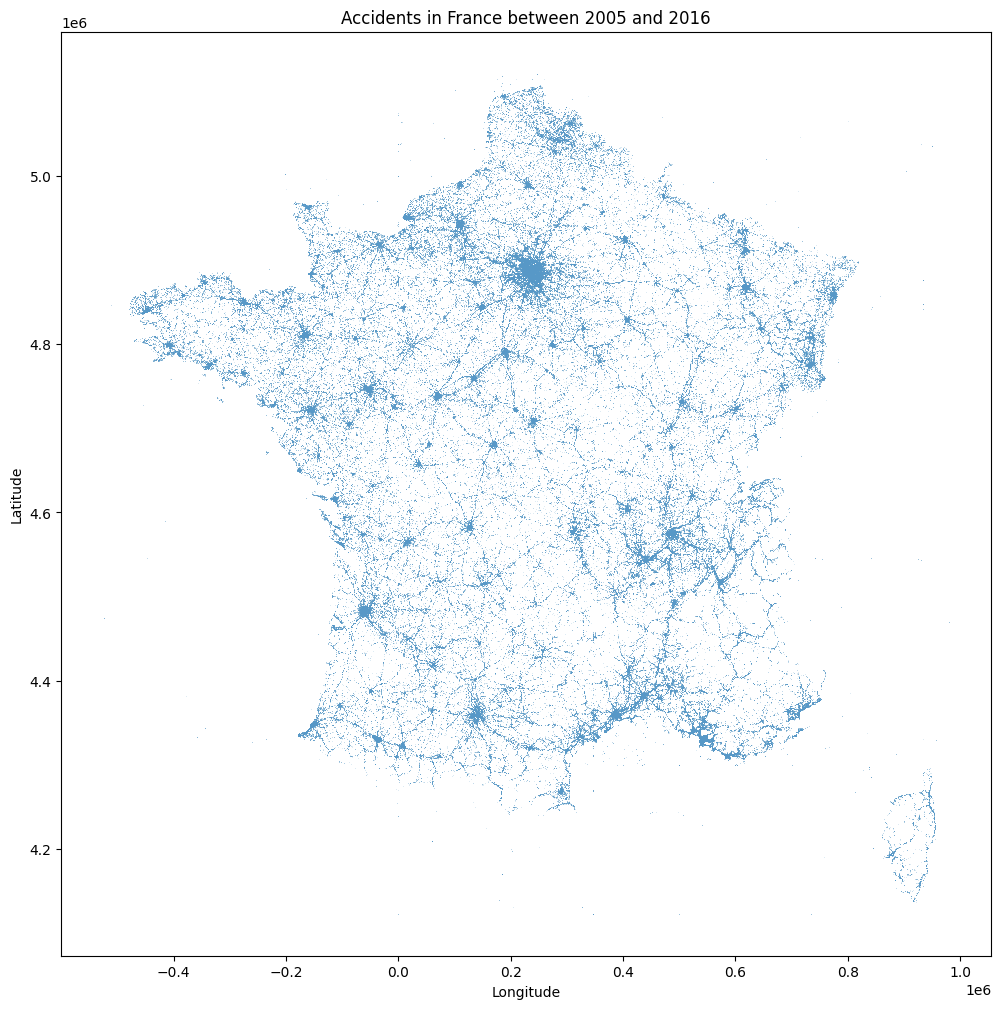

In [101]:
import matplotlib.pyplot as plt

# Scatterplot creation
plt.figure(figsize=(12, 12))
sns.scatterplot(data=data, x='Longitude', y='Latitude', s=0.1)
plt.title("Accidents in France between 2005 and 2016")
plt.show()

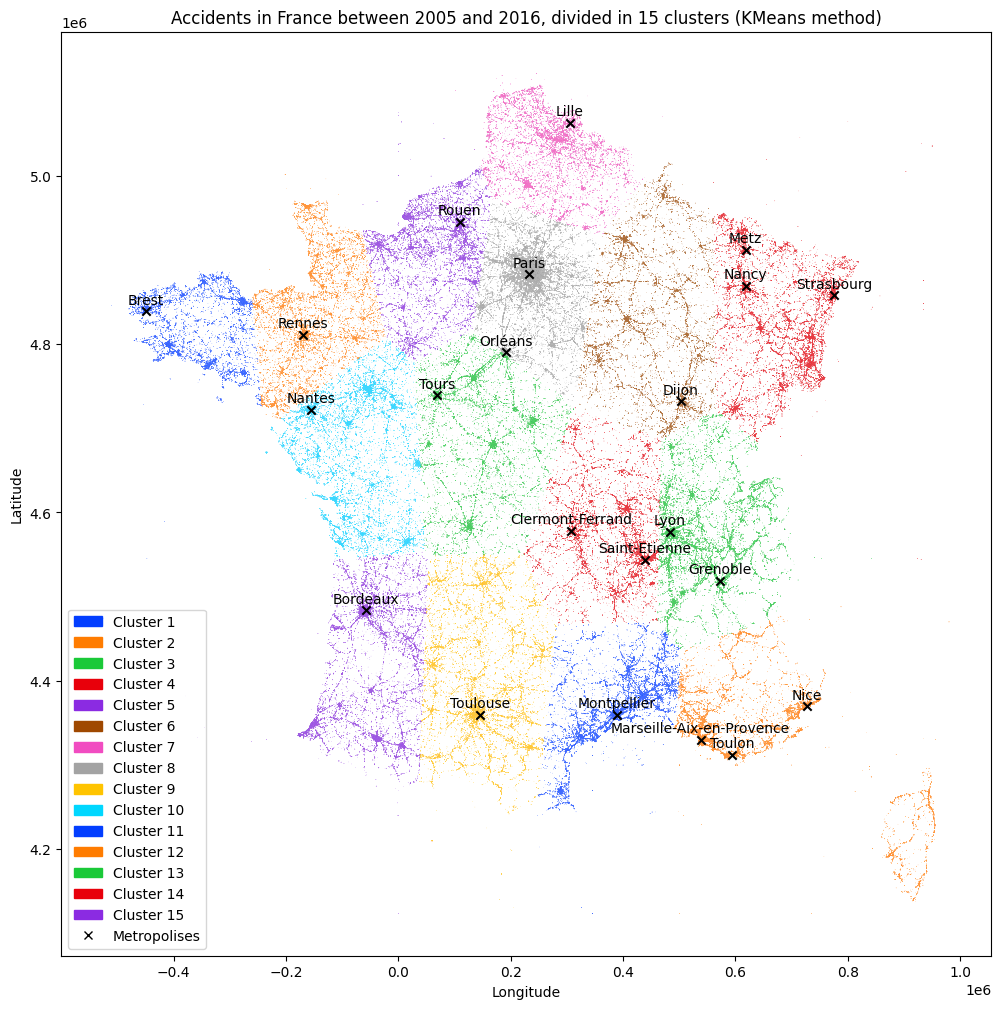

In [102]:
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

kmeans = KMeans(n_clusters=15, random_state=0, n_init='auto').fit(data[['Longitude', 'Latitude']])

labels = kmeans.labels_
cluster_name = ["Cluster "+str(i + 1) for i in set(labels)]

plt.figure(figsize=(12,12))
sns.scatterplot(data=data, x="Longitude", y="Latitude", hue=labels, palette=sns.color_palette("bright", 15), s=0.1)

metropolises_coordinates = {
    "Paris" : (2.33*10**5, 48.83*10**5),
    "Lille" : (3.05*10**5, 50.63*10**5),
    "Rouen" : (1.09*10**5, 49.45*10**5),
    "Metz" : (6.18*10**5, 49.12*10**5),
    "Nancy" : (6.18*10**5, 48.69*10**5),
    "Strasbourg" : (7.75*10**5, 48.58*10**5),
    "Brest" : (-4.49*10**5, 48.39*10**5),
    "Rennes" : (-1.69*10**5, 48.11*10**5),
    "Nantes" : (-1.56*10**5, 47.22*10**5),
    "Tours" : (0.69*10**5, 47.39*10**5),
    "Orléans" : (1.92*10**5, 47.90*10**5),
    "Dijon"  : (5.03*10**5, 47.32*10**5),
    "Clermont-Ferrand" : (3.08*10**5, 45.78*10**5),
    "Lyon" : (4.83*10**5, 45.77*10**5),
    "Saint-Etienne" : (4.39*10**5, 45.44*10**5),
    "Grenoble" : (5.73*10**5, 45.19*10**5),
    "Bordeaux" : (-0.58*10**5, 44.84*10**5),
    "Toulouse" : (1.45*10**5, 43.60*10**5),
    "Montpellier" : (3.89*10**5, 43.60*10**5),
    "Marseille-Aix-en-Provence" : (5.38*10**5, 43.30*10**5),
    "Toulon" : (5.94*10**5, 43.12*10**5),
    "Nice" : (7.27*10**5, 43.70*10**5)
}

for city in metropolises_coordinates:
    plt.scatter(metropolises_coordinates[city][0], metropolises_coordinates[city][1], marker='x', color='black')
    plt.text(metropolises_coordinates[city][0], metropolises_coordinates[city][1] + 0.05*10**5, s=city, ha='center', va='bottom')

legend = []
for i, color in enumerate(sns.color_palette("bright", 15)):
    legend.append(mpatches.Patch(color=color, label=cluster_name[i]))

cross = Line2D([0], [0], label='Metropolises', marker='x', markeredgecolor='black', linestyle='')
legend.append(cross)

plt.legend(handles=legend, loc='lower left')
plt.title("Accidents in France between 2005 and 2016, divided in 15 clusters (KMeans method)")
plt.show()

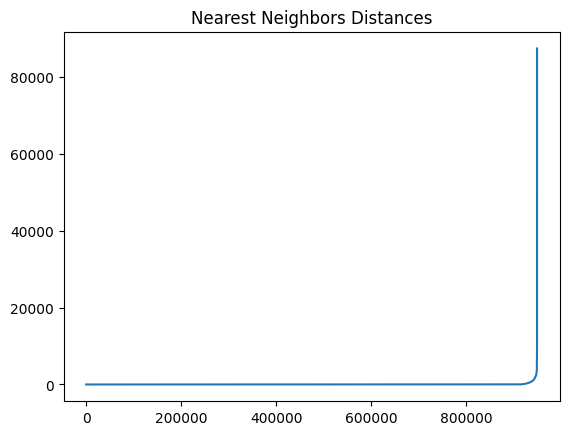

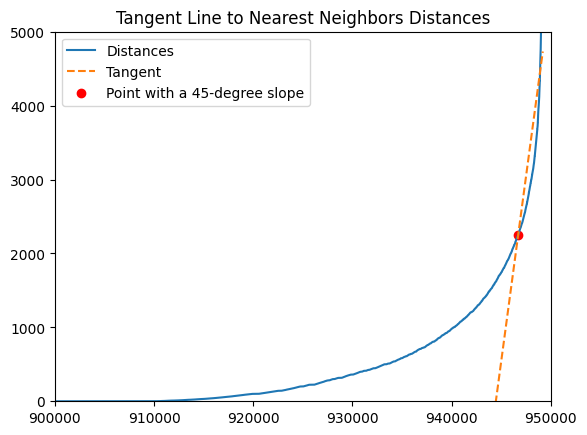

In [103]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(data[['Longitude', 'Latitude']])
distances, indices = neighbors_fit.kneighbors(data[['Longitude', 'Latitude']])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure()
plt.plot(distances)
plt.title("Nearest Neighbors Distances")
plt.show()

plt.figure()
plt.plot(distances, label='Distances')

point_index = np.argmin(np.abs(np.gradient(distances) - 1))
tangent_line = np.arange(len(distances)) - (point_index - distances[point_index])

plt.plot(tangent_line, label=f'Tangent', linestyle='--')
plt.scatter(point_index, distances[point_index], color='red', label='Point with a 45-degree slope')

plt.legend()
plt.axis([900000, 950000, 0, 5000])
plt.title("Tangent Line to Nearest Neighbors Distances")
plt.show()

In [104]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=2250, min_samples=400).fit(data[['Longitude', 'Latitude']])
labels = db.labels_

n_clusters = len(set(labels))
print(f"{n_clusters} clusters found.")

123 clusters found.


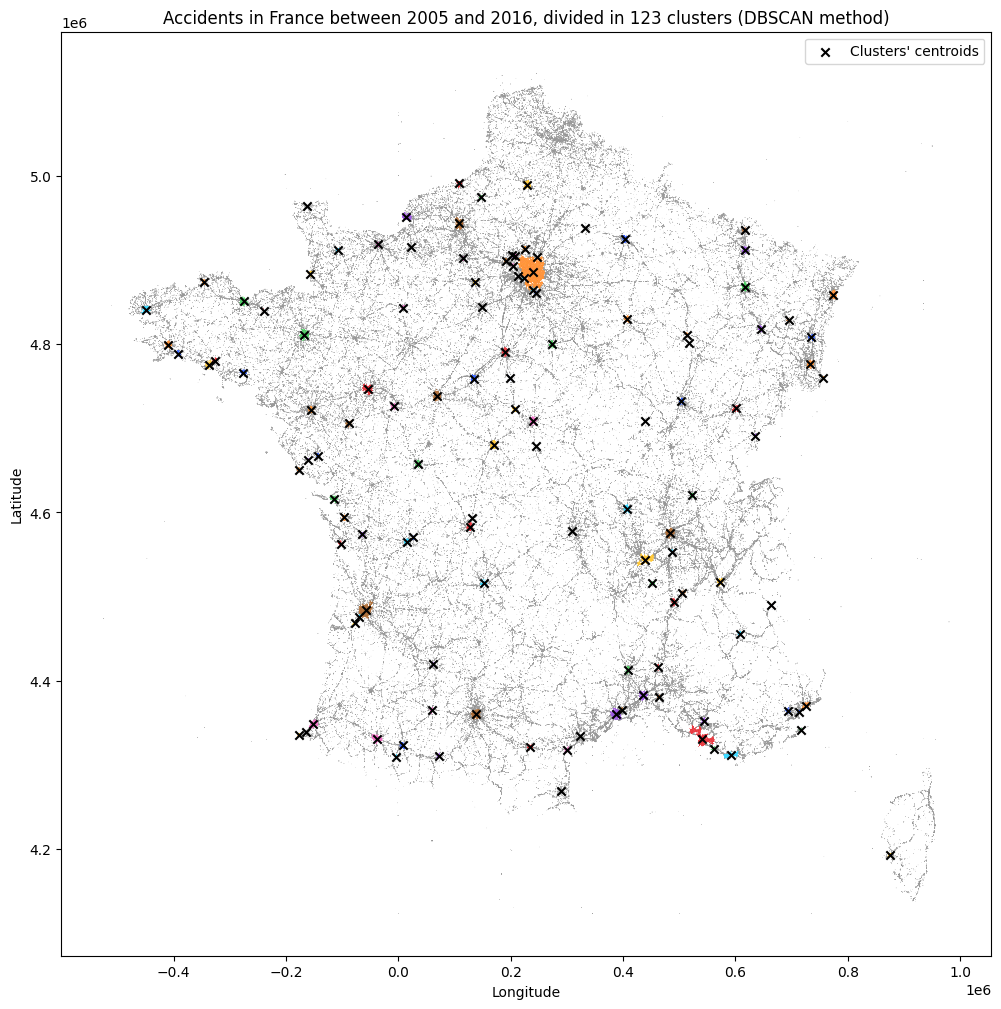

In [105]:
plt.figure(figsize=(12, 12))

custom_palette = {}
palette = sns.color_palette('bright', n_clusters)

k=0
for cluster in set(labels):
    if cluster != -1:
        custom_palette[cluster] = palette[k]
        k+=1
    else:
        custom_palette[cluster] = (0.5, 0.5, 0.5)

data['Cluster'] = labels

sns.scatterplot(data=data, x="Longitude", y="Latitude", hue='Cluster', palette=custom_palette, s=0.1, legend=None)

centroids = data.groupby('Cluster')[['Longitude', 'Latitude']].mean()
plt.scatter(centroids['Longitude'], centroids['Latitude'], marker='x', color='black', label="Clusters' centroids")

plt.legend()
plt.title("Accidents in France between 2005 and 2016, divided in 123 clusters (DBSCAN method)")
plt.show()

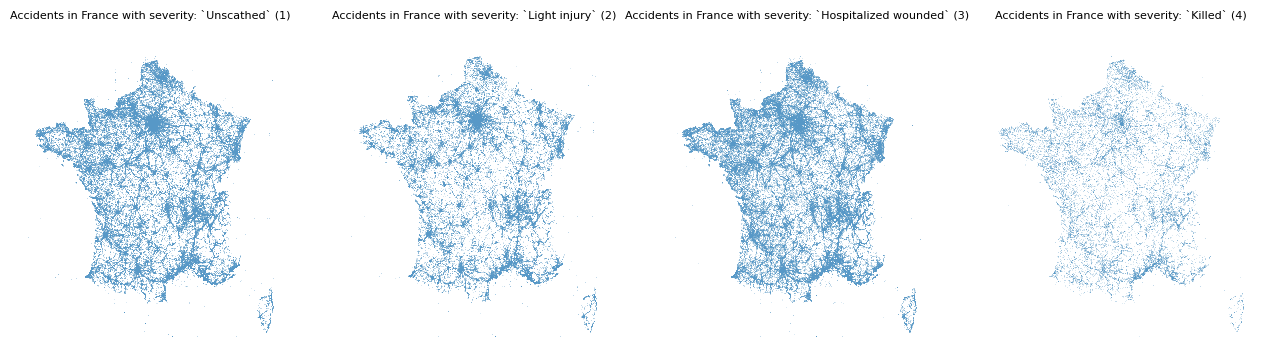

In [113]:
plt.figure(figsize=(16,4))

for i in range(1, 5):
    plt.subplot(1, 4, i)
    sns.scatterplot(data=data.loc[data['Severity']==i], x='Longitude', y='Latitude', s=0.1)
    plt.axis(False)
    plt.title(f"Accidents in France with severity: '{severity_description[i]}' ({i})", fontsize=8)
plt.show()

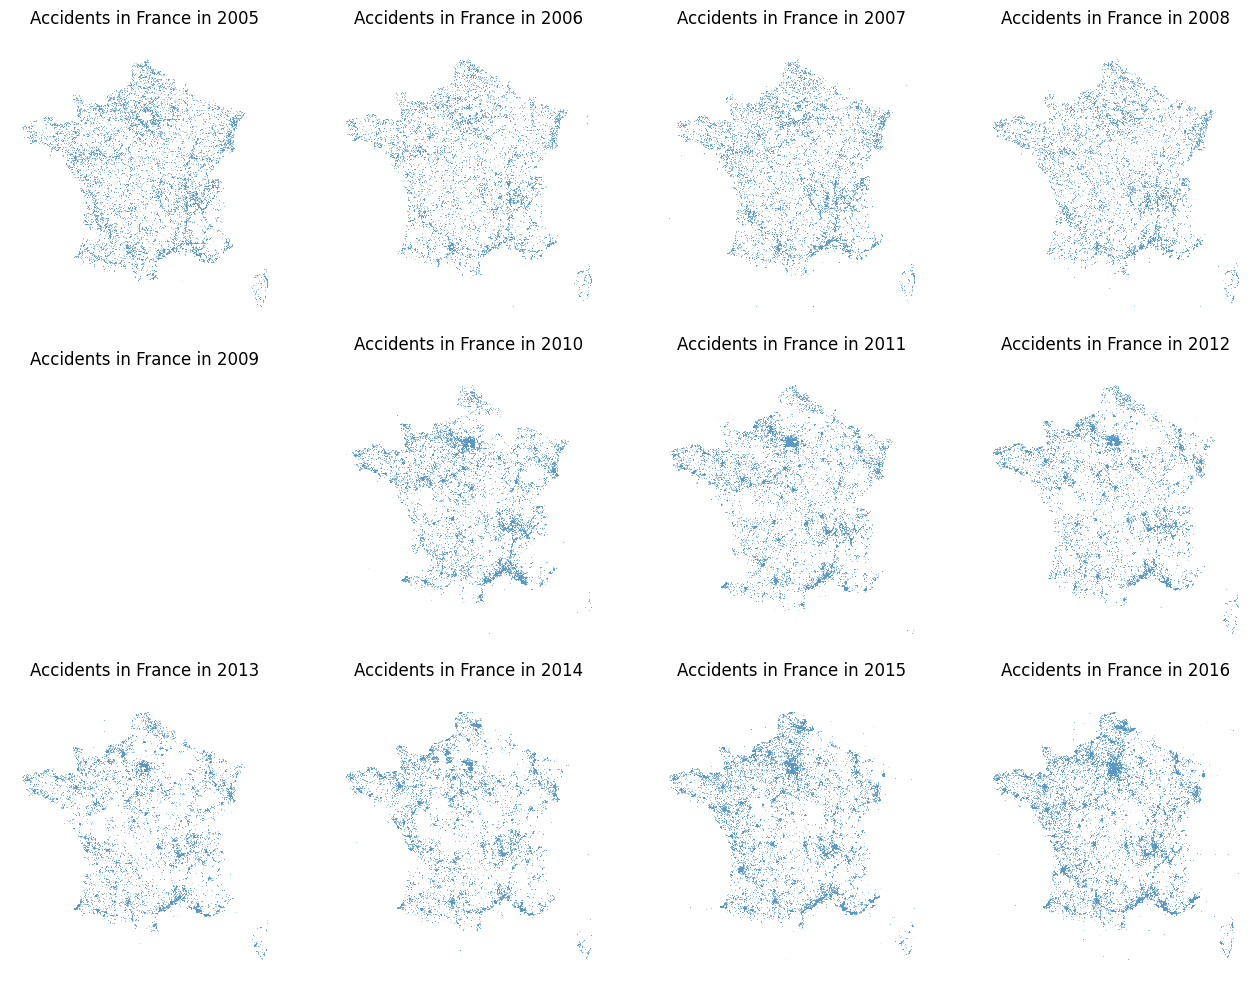

In [107]:
plt.figure(figsize=(16,12))

for i in range(1, 13):
    plt.subplot(3, 4, i)
    sns.scatterplot(data=data.loc[data['Year']==4+i], x='Longitude', y='Latitude', s=0.1)
    plt.axis(False)
    plt.title(f"Accidents in France in {2004 + i}")
plt.show()